In [134]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, execute
from qiskit.visualization import plot_histogram, plot_bloch_multivector, plot_state_qsphere
import numpy as np

In [135]:
#lets start with creating a maximally entangled photon pair 
qc = QuantumCircuit(2, 2)
qc.h(0)  # put first photon in superpositon 
qc.cx(0, 1)
qc.draw()

┌───┐     
q_0: ┤ H ├──■──
     └───┘┌─┴─┐
q_1: ─────┤ X ├
          └───┘
c: 2/══════════

In [136]:
# lets check the statevector
bkend =Aer.get_backend('statevector_simulator')
job = execute(qc, bkend)
sv = job.result().get_statevector(qc, decimals=3)
print(sv)

[0.70710678+0.j 0.        +0.j 0.        +0.j 0.70710678+0.j]


In [137]:
# Create entangled photon pair and measure it in X basis , results are same
qc = QuantumCircuit(2, 2)
qc.h(0)  # put first photon in superpositon 
qc.cx(0, 1)
qc.h([0,1])
qc.draw()

┌───┐     ┌───┐
q_0: ┤ H ├──■──┤ H ├
     └───┘┌─┴─┐├───┤
q_1: ─────┤ X ├┤ H ├
          └───┘└───┘
c: 2/═══════════════

In [138]:
# measure and check the state vector
bkend =Aer.get_backend('statevector_simulator')
job = execute(qc, bkend)
sv = job.result().get_statevector(qc, decimals=3)
print(sv)

[0.70710678-8.65956056e-17j 0.        +8.65956056e-17j
 0.        +8.65956056e-17j 0.70710678-8.65956056e-17j]


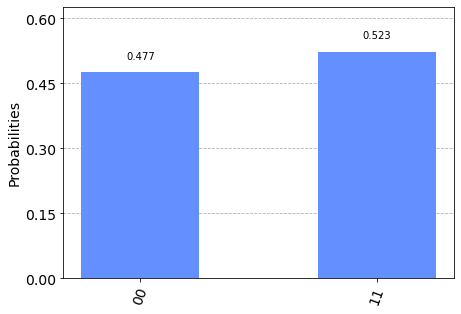

In [139]:
# run QASm simulator to capture measurement statistics
qc.measure([0,1], [0,1])
bkend = BasicAer.get_backend('qasm_simulator')
job = execute(qc, bkend, shots=1000)
counts = job.result().get_counts(qc)
plot_histogram(counts)

In [140]:
from qiskit.circuit.library import XGate, YGate, ZGate, IGate
# Calculate an operator associated with the rotation about an arbitary axis
def ArbRotOperator(ncap, angle):
    Ux = XGate(); Uy =  YGate();   Uz = ZGate() ; Ui = IGate();
# OR if you want you can define Paulis 
# Px = np.array([[0,1],[1,0]]); Py = np.array([[0,-1.j],[1.j,0]]); Pz = np.array([[1,0],[0,-1]])
    Oper_r = np.dot(np.cos(angle/2), Ui.to_matrix()) 
    ns = ncap[0]*Ux.to_matrix() + ncap[1]*Uy.to_matrix() + ncap[2]*Uz.to_matrix()
    Oper_i = 1.j * np.sin(angle/2)*ns
    Oper = Oper_r - Oper_i 
    Multiplier = np.exp(1.j*np.pi/2) # take care of global phase
    Oper = Multiplier * Oper 
    return Oper

In [141]:
from qiskit.quantum_info.operators.operator import Operator
# define a function to map measurement correlations while measuring in differnt bases
def EntangCirCorrelation(ncap) :
    qc = QuantumCircuit(2,2)
    qc.h(0)
    qc.cx(0,1)
    angle = np.pi #  rotate by 180 degrees
    cust_Oper = Operator(ArbRotOperator(ncap, np.pi))
    qc.unitary(cust_Oper,[0],label='MB')
    qc.measure([0,1],[0,1])
    bkend = BasicAer.get_backend('qasm_simulator')
    shots=2048
    job = execute(qc, bkend, shots=shots)
    counts = job.result().get_counts(qc)
#    print(counts)
    if '00' in counts.keys() and '11' in counts.keys() :  
        cor = (counts.get("00") + counts.get("11")) / shots
    else :
        cor = 0
    return cor

In [151]:
# define arrays for quantum and classical plots
x_q=[]
y_q=[]
x_c=[]
y_c=[]

num_orientation = 36 # number of measurement basis in a full cycle  

for iter in range(num_orientation+1):   # move from measurement along Z axis to measurement along the X axis
    p_angle = iter * (np.pi/num_orientation)   
    # determine angle in radians to get corrdinates of arbitary axis and calculate rotational matrix 
    ncap = np.array([np.sin(p_angle), 0, np.cos(p_angle)])
    y_q.append(EntangCirCorrelation(ncap))
    x_angle = p_angle * 180/np.pi # get angle in degrees
    x_q.append(x_angle)  # store angle in X array for plotting
    x_c.append(x_angle) 
    # linear relations in classical case
    if x_angle <= 90 :
        y_c.append(1-1/90*(x_angle))
    else :
        y_c.append((x_angle-90)/90)
      

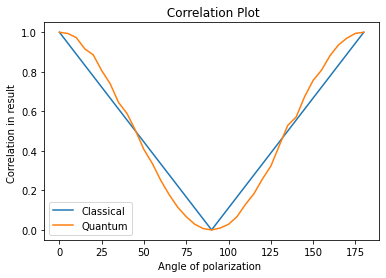

In [152]:
# plot classical predictions vs. quantum observations. take note of values at angles of22.5, 67.5,112.5 and 157.5 Degrees
import matplotlib.pyplot as plt
plt.plot(x_c, y_c)
plt.plot(x_q, y_q)
plt.xlabel('Angle of polarization ')
plt.ylabel('Correlation in result ')
plt.title(' Correlation Plot')
plt.legend(["Classical", "Quantum"])
plt.show()

In [ ]:
# end of program